In [180]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [181]:
def gen_sample(batch_size, N_agents, in_dim = None, L = None):
    """ 
        generates an inital states in [0,L1] x [0,L2] x ... x [0, Ln] of shape [Batch_size, in_dim]
    """
    #### Region with pdf > 0
    if in_dim is None and L is None:
        raise ValueError("Need either L or in dim to be set")
    if in_dim is None:
        in_dim = len(L)
    if L is None:
        L = [1. for _ in range(in_dim)]
    x = torch.rand(batch_size, N_agents, in_dim).abs()
    for i in range(len(L)):
        x[:, :, i] = torch.clamp(x[:, :, i],min = 0.6, max=0.9)
    return x


In [182]:
N_Agents = 1
in_dim = 1
batch_size = 256
n_samples = 2048
timesteps = 30
lam = 0.5
k_max = 2
control_energy_reg = 0#1e-6 ### regularization on maximum control energy
u_max = 100 # does not do anything currently
thres = 0#1e-2 ### softness on constraint (will penalize when this much outside of rect)
dropout = 0


In [183]:
densties = ['custom']
regions = [
        torch.tensor([[.0, .3]]),
        torch.tensor([[.6, .9]])
        ]
weights = [.5, .5]

In [184]:
def custom_pdf(x):
    """
     Define a custom probability density function (PDF).
    """
    #x = x.item()
    #return np.where(((x > 0) & (x < 1)), 1, 0)
    #return np.where(((x > 0) & (x < 0.3)) | ((x > 0.6) & (x < 0.9)), 5 / 3, 0)
    return np.where((x > 0.6) & (x < 0.9),3, 0)

In [185]:
import Ergodic_Loss
import Recursive_KAN
import sys
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Ergodic_Loss.py') 
sys.path.append(r'C:\Users\JP\Documents\TU Berlin\Master\Code_RNN\Recursive_kan\Recursive_KAN.py') 
import importlib
importlib.reload(Ergodic_Loss)
importlib.reload(Recursive_KAN)
model = Recursive_KAN.KAN_RNN_Layer(N_Agents = N_Agents, in_dim = in_dim, hidden = 128, depth = 2, n_timesteps = timesteps,sys_param_lam= lam, u_max = u_max, network_type='multi', dropout = dropout)
model.init_hidden(batch_size = batch_size)
criterion = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max, thres = thres, control_energy_reg = control_energy_reg, density = 'custom',verbose = False, pdf = custom_pdf, max_pdf = 3, num_samples = 100000)


In [ ]:
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=10,          # Number of iterations for the first restart
    T_mult=2,        # Factor by which T_0 is multiplied after each restart
    eta_min=0        # Minimum learning rate after annealing
)


In [ ]:
def test_crit(model):
    test = Ergodic_Loss.Ergodicity_Loss(N_Agents = N_Agents, n_timesteps = timesteps,L = None, in_dim = in_dim, k_max = k_max, thres = thres, control_energy_reg = control_energy_reg, density = 'custom',verbose = False, pdf = custom_pdf, max_pdf = 3, num_samples = 1000)
    test.verbose = True
    inital_state = gen_sample(batch_size = 256, N_agents = N_Agents, in_dim = in_dim)
    model.init_hidden(batch_size = 256)
    outs, control = model(inital_state)
    test(x = outs, u = control)

model: tensor(1.4055, grad_fn=<SelectBackward0>) target: tensor(-0.9629)
4.875364780426025
per iter: 0.4570913314819336 total time: 182.83653259277344
model: tensor(1.4114, grad_fn=<SelectBackward0>) target: tensor(-0.9629)
4.0069098472595215
model: tensor(1.4000, grad_fn=<SelectBackward0>) target: tensor(-0.9629)
4.166962146759033
model: tensor(1.3980, grad_fn=<SelectBackward0>) target: tensor(-0.9629)
4.367912292480469
model: tensor(1.4022, grad_fn=<SelectBackward0>) target: tensor(-0.9629)
3.977975368499756
model: tensor(1.4041, grad_fn=<SelectBackward0>) target: tensor(-0.9629)
3.987478256225586
model: tensor(1.4027, grad_fn=<SelectBackward0>) target: tensor(-0.9629)
3.9941561222076416
model: tensor(1.4098, grad_fn=<SelectBackward0>) target: tensor(-0.9629)
3.996983528137207
Epoch [1/50], Loss: 4.171718
model: tensor(1.4106, grad_fn=<SelectBackward0>) target: tensor(-0.9629)
3.9997057914733887
model: tensor(1.4112, grad_fn=<SelectBackward0>) target: tensor(-0.9629)
4.00248718261718

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3.7240450382232666
Epoch [50/50], Loss: 3.734683


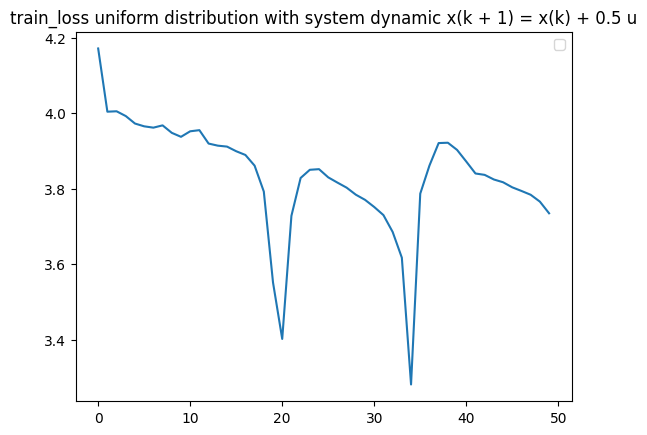

Training Complete!


In [ ]:
import time
tested = True
count = 0
criterion.verbose = True
epochs = 50  # Number of epochs to train
train_loss = []
test_loss = []
model.train()  # Set the model to training mode
show = True
for epoch in range(epochs):
    running_loss = 0.0 
    for samples in range(n_samples // batch_size):
        start_time = time.time()
        model.init_hidden(batch_size = batch_size)
        optimizer.zero_grad()
        outputs, control = model(gen_sample(batch_size = batch_size, N_agents = N_Agents, in_dim = in_dim))
        loss = criterion(x = outputs, u = control) + model.penalty #* 1e-2 ## punishment on leaving the rect
        loss.backward()
        #print(loss, "captured")
        optimizer.step()
        running_loss += loss.item()
        print(loss.item())
        #print(running_loss, "added")
        #scheduler.step(epoch + samples / (n_samples // batch_size))
        #print(optimizer.param_groups[0]['lr'], 'learning rate'
        if show:
            show = False
            criterion.verbose = True
            print("per iter:", time.time()- start_time,"total time:" , (time.time()- start_time) * (n_samples / batch_size) * epochs)
    
    avg_loss = running_loss / (n_samples // batch_size)
    train_loss.append(avg_loss)
    #if (avg_loss < 0.1) and (tested):
    #    test_crit(model)
    #    count += 1
    #    if count > 5:
    #        tested = False

    #if avg_loss < 0.004: ## converged
    #    break
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.6f}")
plt.plot(train_loss)
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

In [ ]:
criterion.verbose = True
inital_state = gen_sample(batch_size = 256, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 256)
outs, control = model(inital_state)
criterion(x = outs, u = control)

model: tensor(0.9732, grad_fn=<SelectBackward0>) target: tensor(-0.9629)


tensor(2.7806, grad_fn=<AddBackward0>)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


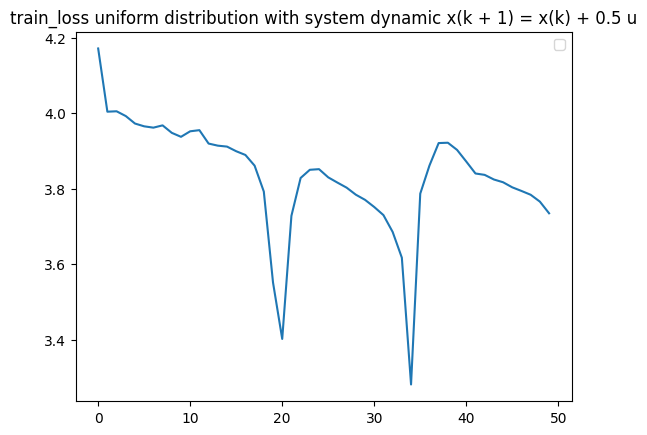

Training Complete!


In [ ]:
plt.plot(train_loss[-500:])
plt.title(f'train_loss uniform distribution with system dynamic x(k + 1) = x(k) + {lam} u')
plt.legend()
plt.show()
print("Training Complete!")

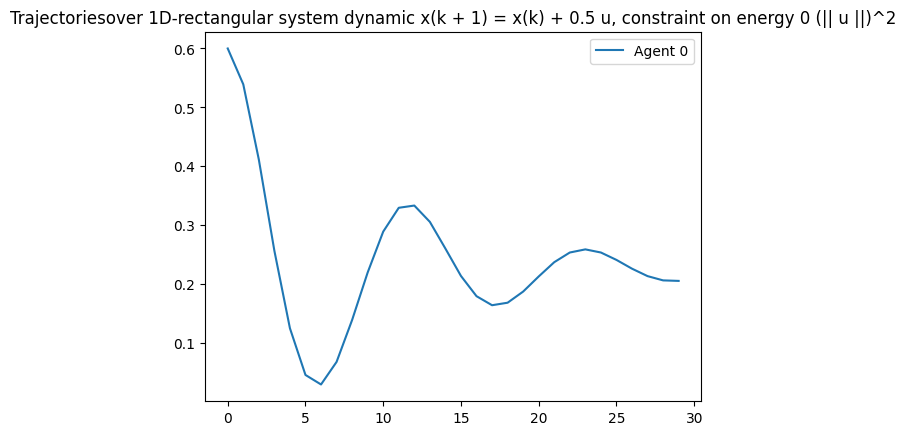

model: tensor(0.9732, grad_fn=<SelectBackward0>) target: tensor(-0.9629)


tensor(2.8422, grad_fn=<AddBackward0>)

In [ ]:
#plot trajectory
#model.eval()
inital_state = gen_sample(batch_size = 1, N_agents = N_Agents, in_dim = in_dim)
model.init_hidden(batch_size = 1)
outs, control = model(inital_state)
for j in range(N_Agents):
    plt.plot(outs[:,:,j,:].squeeze().detach(), label = f'Agent {j}')
plt.title(f'Trajectoriesover 1D-rectangular system dynamic x(k + 1) = x(k) + {lam} u, constraint on energy {control_energy_reg} (|| u ||)^2')
plt.legend()
plt.show()
criterion(x = outs, u = control)

